# Essentia Python examples

This Jupyter notebook demonstrates various typical examples of using Essentia in Python.

## Computing features with MusicExtractor

[MusicExtractor](http://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) is a multi-purpose algorithm for feature extraction from files (see the complete list of computed features [here](http://essentia.upf.edu/documentation/streaming_extractor_music.html)). It combines many algorithms and is also used inside the Essentia's command-line Music Extractor. For any given input filename, all computed features are stored in two output Pools which you can access for your needs or store to a file. One of the pools contains raw frames data, while another one contains aggregated statistics across frames.

In [1]:
# This is how the audio we want to process sounds like
import IPython
IPython.display.Audio('../../../test/audio/recorded/dubstep.flac')

In [2]:
import essentia
import essentia.standard as es

# Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'], 
                                              rhythmStats=['mean', 'stdev'], 
                                              tonalStats=['mean', 'stdev'])('../../../test/audio/recorded/dubstep.flac')

# See all feature names in the pool in a sorted order
print(sorted(features.descriptorNames()))


['lowlevel.average_loudness', 'lowlevel.barkbands.mean', 'lowlevel.barkbands.stdev', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands.mean', 'lowlevel.erbbands.stdev', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.gfcc.cov', 'lowlevel.gfcc.icov', 'lowlevel.gfcc.mean

You can then access particular values in the pools:

In [56]:
print("Filename:", features['metadata.tags.file_name'])
print("-"*80)
print("Replay gain:", features['metadata.audio_properties.replay_gain'])
print("EBU128 integrated loudness:", features['lowlevel.loudness_ebu128.integrated'])
print("EBU128 loudness range:", features['lowlevel.loudness_ebu128.loudness_range'])
print("-"*80)
print("MFCC mean:", features['lowlevel.mfcc.mean'])
print("-"*80)
print("BPM:", features['rhythm.bpm'])
print("Beat positions (sec.)", features['rhythm.beats_position'])
print("-"*80)
print("Key/scale estimation (using a profile specifically suited for electronic music):", 
      features['tonal.key_edma.key'], features['tonal.key_edma.scale'])
    

Filename: dubstep.flac
--------------------------------------------------------------------------------
Replay gain: -13.708175659179688
EBU128 integrated loudness: -10.151906967163086
EBU128 loudness range: 0.6067428588867188
--------------------------------------------------------------------------------
MFCC mean: [-670.34771729   84.01703644   24.20178986   -4.55752945    8.39075661
   -1.40908575    6.48751211    9.55739212    1.58020043    9.26296902
   -0.74807823    5.43698931   -4.19750071]
--------------------------------------------------------------------------------
BPM: 139.98114013671875
Beat positions (sec.) [ 0.42956915  0.85913831  1.30031741  1.71827662  2.14784575  2.57741499
  2.9953742   3.42494321  3.86612248  4.29569149  4.72526073  5.15482998
  5.58439922  6.01396799  6.4319272 ]
--------------------------------------------------------------------------------
Key/scale estimation (using a profile specifically suited for electronic music): G# minor


## Beat detection and BPM histogram

In this example we are going to look at how to perform beat tracking using [RhythmExtractor2013](http://essentia.upf.edu/documentation/reference/std_RhythmExtractor2013.html), mark the extractred beats on the audio using the [AudioOnsetsMarker](http://essentia.upf.edu/documentation/reference/std_AudioOnsetsMarker.html) algorithm and write those to file using [MonoWriter](http://essentia.upf.edu/documentation/reference/std_MonoWriter.html).


In [51]:
from essentia.standard import *

# Loading audio file
audio = MonoLoader(filename='../../../test/audio/recorded/dubstep.flac')()

# Compute beat positions and BPM
rhythm_extractor = RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)

print("BPM:", bpm)
print("Beat positions (sec.):", beats)
print("Beat estimation confidence:", beats_confidence)

# Mark beat positions on the audio and write it to a file
# Let's use beeps instead of white noise to mark them, as it's more distinctive
marker = AudioOnsetsMarker(onsets=beats, type='beep')
marked_audio = marker(audio)
MonoWriter(filename='audio/dubstep_beats.flac')(marked_audio)

BPM: 139.98114013671875
Beat positions (sec.): [ 0.42956915  0.85913831  1.30031741  1.71827662  2.14784575  2.57741499
  2.9953742   3.42494321  3.86612248  4.29569149  4.72526073  5.15482998
  5.58439922  6.01396799  6.4319272 ]
Beat estimation confidence: 3.9443612098693848


We can now listen to the resulting audio with beats marked by beeps. We can also visualize beat estimations.

In [40]:
import IPython
IPython.display.Audio('audio/dubstep_beats.flac')

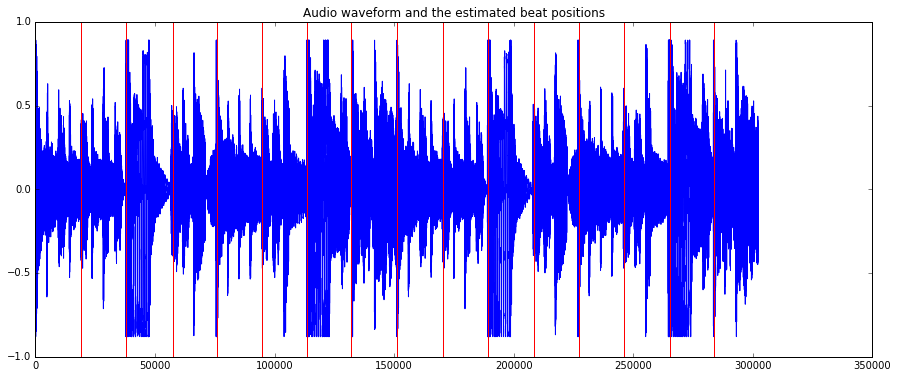

In [49]:
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

plot(audio)
for beat in beats:
    plt.axvline(x=beat*44100, color='red')

plt.title("Audio waveform and the estimated beat positions")

The BPM value output by RhythmExtactor2013 is the average of all BPM estimates done for each interval between two consecutive beats. Alternatively, we could analyze the distribution of all those intervals using [BpmHistogramDescriptors](http://essentia.upf.edu/documentation/reference/std_BpmHistogramDescriptors.html). This would especially make sense for music with a varying rhythm (which is not the case in our example, but anyways...).

Overall BPM (estimated before): 140.0
First histogram peak: 140.0 bpm
Second histogram peak: 0.0 bpm


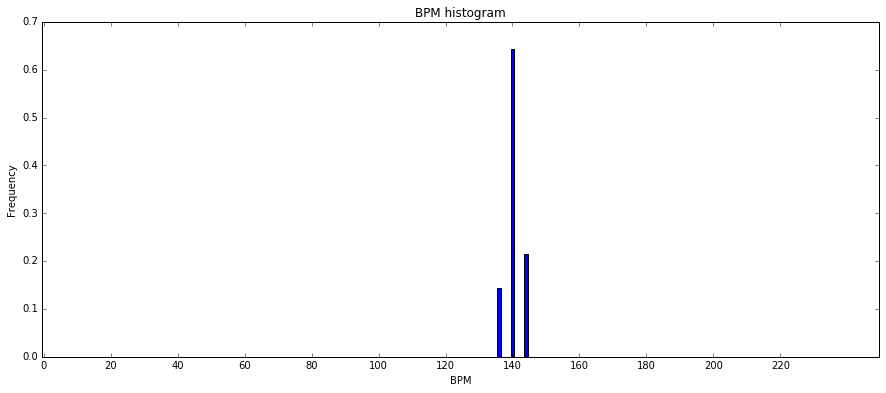

In [54]:
peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = BpmHistogramDescriptors()(beats_intervals)

print("Overall BPM (estimated before): %0.1f" % bpm)
print("First histogram peak: %0.1f bpm" % peak1_bpm)
print("Second histogram peak: %0.1f bpm" % peak2_bpm)

fig, ax = plt.subplots()
ax.bar(range(len(histogram)), histogram, width=1)
ax.set_xlabel('BPM')
ax.set_ylabel('Frequency')
plt.title("BPM histogram")
ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
plt.show()

## Onset detection

In this example we are going to look at how to perform onset detection and mark onsets on the audio using the [AudioOnsetsMarker](http://essentia.upf.edu/documentation/reference/std_AudioOnsetsMarker.html) algorithm.

Onset detection consists of two main phases:
- Compute an onset detection function, which is a function describing the evolution of some parameters, which might be representative of whether we might find an onset or not
- Decide onset locations in the signal based on a number of these detection functions

The [OnsetDetection](http://essentia.upf.edu/documentation/reference/std_OnsetDetection.html) algorithm estimates various onset detection functions for an audio frame given its spectrum. [Onsets](http://essentia.upf.edu/documentation/reference/std_Onsets.html) detects onsets given a matrix with values of onset detection functions in each frame.

It might be hard to hear the sound of hihats as it gets masked by the onset beeps in the mono signal. As an alternative, we can store both the original sound and the beeps in a stereo signal putting them separately into left and right channels using [StereoMuxer](http://essentia.upf.edu/documentation/reference/std_StereoMuxer.html) and [AudioWriter](http://essentia.upf.edu/documentation/reference/std_AudioWriter.html).


In [77]:
# Loading audio file
audio = MonoLoader(filename='../../../test/audio/recorded/hiphop.mp3')()

# Phase 1: compute the onset detection function
# The OnsetDetection algorithm provides various onset detection functions. Let's use two of them.

od1 = OnsetDetection(method='hfc')
od2 = OnsetDetection(method='complex')

# Let's also get the other algorithms we will need, and a pool to store the results
w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
pool = essentia.Pool()

# Computing onset detection functions.
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mag, phase, = c2p(fft(w(frame)))
    pool.add('features.hfc', od1(mag, phase))
    pool.add('features.complex', od2(mag, phase))

# Phase 2: compute the actual onsets locations
onsets = Onsets()

onsets_hfc = onsets(# this algo expects a matrix, not a vector
                    essentia.array([ pool['features.hfc'] ]),

                    # you need to specify weights, but as there is only a single
                    # function, it doesn't actually matter which weight you give it
                    [ 1 ])

onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ])


# Mark onsets on the audio, which we'll write back to disk
# We use beeps instead of white noise and stereo signal as it's more distinctive

silence = [0.] * len(audio)

beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
AudioWriter(filename='audio/hiphop_onsets_hfc_stereo.mp3', format='mp3')(StereoMuxer()(audio, beeps_hfc))

beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)
AudioWriter(filename='audio/hiphop_onsets_complex_stereo.mp3', format='mp3')(StereoMuxer()(audio, beeps_complex))

We can now go listen to the resulting audio files to see which onset detection function works better.

In [68]:
IPython.display.Audio('../../../test/audio/recorded/hiphop.mp3')

In [79]:
IPython.display.Audio('audio/hiphop_onsets_hfc_stereo.mp3')

In [74]:
IPython.display.Audio('audio/hiphop_onsets_complex_stereo.mp3')

Finally, inspecting the plots with onsets marked by vertical lines, we can easily see how the HFC method picks up the highhats, which the complex method also detects the kicks.

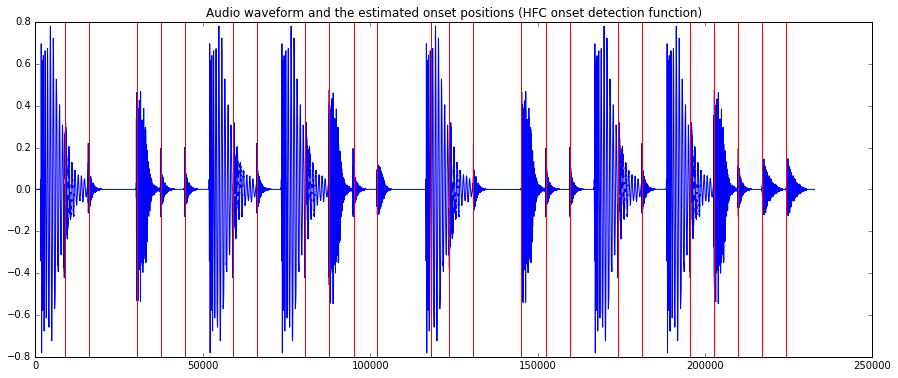

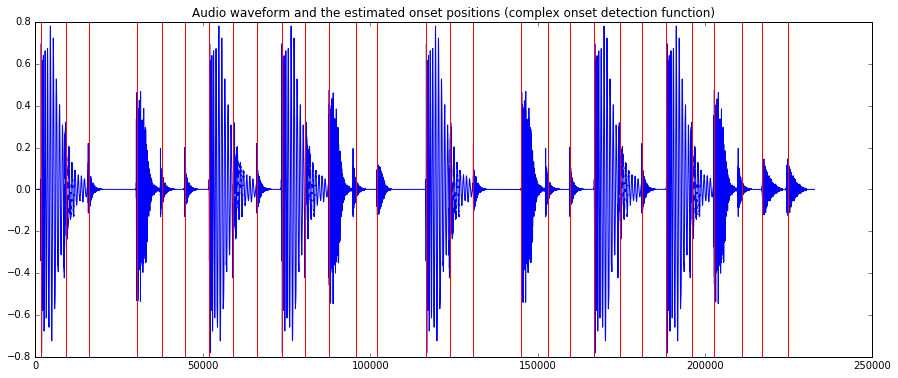

In [80]:
plot(audio)
for onset in onsets_hfc:
    plt.axvline(x=onset*44100, color='red')

plt.title("Audio waveform and the estimated onset positions (HFC onset detection function)")
plt.show()

plot(audio)
for onset in onsets_complex:
    plt.axvline(x=onset*44100, color='red')

plt.title("Audio waveform and the estimated onset positions (complex onset detection function)")

## Melody detection
In this example we will analyse the pitch contour of the predominant melody in an audio recording using the [PredominantPitchMelodia](http://essentia.upf.edu/documentation/reference/std_PredominantPitchMelodia.html) algorithm. This algorithm outputs a time series (sequence of values) with the instantaneous pitch value (in Hertz) of the perceived melody. It can be used with both monophonic and polyphonic signals.

Duration of the audio sample [sec]:
14.22859410430839


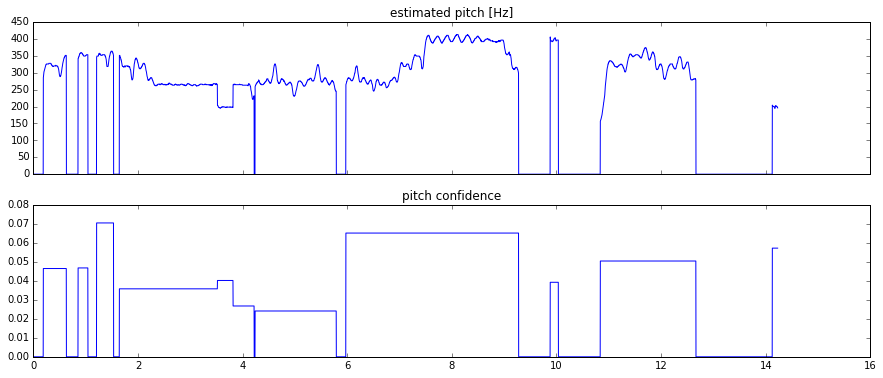

In [96]:
import numpy

# Load audio file; it is recommended to apply equal-loudness filter for PredominantPitchMelodia 
loader = EqloudLoader(filename='../python/musicbricks-tutorials/flamenco.wav', sampleRate=44100)
audio = loader()
print("Duration of the audio sample [sec]:")
print(len(audio)/44100.0)

# Extract the pitch curve
# PitchMelodia takes the entire audio signal as input (no frame-wise processing is required)

pitch_extractor = PredominantPitchMelodia(frameSize=2048, hopSize=128)
pitch_values, pitch_confidence = pitch_extractor(audio)

# Pitch is estimated on frames. Compute frame time positions
pitch_times = numpy.linspace(0.0,len(audio)/44100.0,len(pitch_values) )

# Plot the estimated pitch contour and confidence over time
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(pitch_times, pitch_values)
axarr[0].set_title('estimated pitch [Hz]')
axarr[1].plot(pitch_times, pitch_confidence)
axarr[1].set_title('pitch confidence')
plt.show()

Let's listen to the estimated pitch and compare it to the original audio.

In [105]:
# TODO

## Tonality analysis (HPCP, key and scale)

In this example we will analyze tonality of a music track. We will analyze the spectrum of an audio signal, find out its spectral peaks using [SpectralPeak](http://essentia.upf.edu/documentation/reference/streaming_SpectralPeaks.html) and then estimate the harmonic pitch class profile using the [HPCP](http://essentia.upf.edu/documentation/reference/streaming_HPCP.html) algorithm. Finally, we will estimate key and scale of the track based on its HPCP value using the [Key](http://essentia.upf.edu/documentation/reference/streaming_Key.html) algorithm.

In this particular case, it is easier to write the code in streaming mode as it is much simpler.

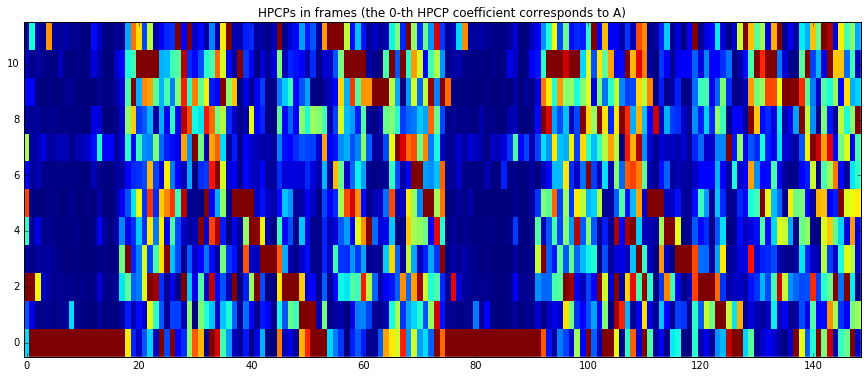

Estimated key and scale: A minor


In [104]:
import essentia.streaming as ess

# Initialize algorithms we will use
loader = ess.MonoLoader(filename='../../../test/audio/recorded/dubstep.flac')
framecutter = ess.FrameCutter(frameSize=4096, hopSize=2048, silentFrames='noise')
windowing = ess.Windowing(type='blackmanharris62')
spectrum = ess.Spectrum()
spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                  magnitudeThreshold=0.00001,
                                  minFrequency=20,
                                  maxFrequency=3500, 
                                  maxPeaks=60)

# Use default HPCP parameters for plots, however we will need higher resolution 
# and custom parameters for better Key estimation

hpcp = ess.HPCP()
hpcp_key = ess.HPCP(size=36, # we will need higher resolution for Key estimation
                    referenceFrequency=440, # assume tuning frequency is 44100.
                    bandPreset=False,
                    minFrequency=20,
                    maxFrequency=3500,
                    weightType='cosine',
                    nonLinear=False,
                    windowSize=1.)

key = ess.Key(profileType='edma', # Use profile for electronic music
              numHarmonics=4,
              pcpSize=36,
              slope=0.6,
              usePolyphony=True,
              useThreeChords=True)

# Use pool to store data
pool = essentia.Pool() 

# Connect streaming algorithms
loader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> spectrum.frame
spectrum.spectrum >> spectralpeaks.spectrum
spectralpeaks.magnitudes >> hpcp.magnitudes
spectralpeaks.frequencies >> hpcp.frequencies
spectralpeaks.magnitudes >> hpcp_key.magnitudes
spectralpeaks.frequencies >> hpcp_key.frequencies
hpcp_key.hpcp >> key.pcp
hpcp.hpcp >> (pool, 'tonal.hpcp')
key.key >> (pool, 'tonal.key_key')
key.scale >> (pool, 'tonal.key_scale')
key.strength >> (pool, 'tonal.key_strength')

# Run streaming network
essentia.run(loader)

# Plot HPCP
imshow(pool['tonal.hpcp'].T, aspect='auto', origin='lower', interpolation='none')
plt.title("HPCPs in frames (the 0-th HPCP coefficient corresponds to A)")
show()

print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])

## Fingerprinting
### Using Chromaprint wrapper to identify audio with AcousticID

[Chromaprint](https://oxygene.sk/2011/01/how-does-chromaprint-work/) is a fingerprinting algorithm based on chroma features. [AcoustID](https://acoustid.org) is a web service that relies on chromaprints in order to identify tracks from the MusicBrainz database.

Queries to AcousticID requires a **client** key, the song **duration** and the **fingerprint**. Additionally, a query can ask for extra metadata from the MusicBrainz database using the field **meta** (https://acoustid.org/webservice).

Essentia provides a wrapper algorithm, [Chromaprinter]((http://essentia.upf.edu/documentation/reference/std_Chromaprinter.html)), for computing fingerprints with the Chromaprint library. In the standard mode, a fingerprint is computed for the whole audio duration and it can be used to generate a query as in the example below:

In [4]:
# the specified file is not provided with this notebook, try using your own music instead
audio = es.MonoLoader(filename='Desakato-Tiempo de cobardes.mp3', sampleRate=44100)()
fingerprint = es.Chromaprinter()(audio)

client = 'hGU_Gmo7vAY' # This is not a valid key. Use your key.
duration = len(audio) / 44100.

# Composing a query asking for the fields: recordings, releasegroups and compress.
query = 'http://api.acoustid.org/v2/lookup?client=%s&meta=recordings+releasegroups+compress&duration=%i&fingerprint=%s' \
%(client, duration, fingerprint)

from six.moves import urllib
page = urllib.request.urlopen(query)
print(page.read())

{"status": "ok", "results": [{"recordings": [{"artists": [{"id": "b02d0e59-b9c2-4009-9ebd-bfac7ffa0ca3", "name": "Desakato"}], "duration": 129, "releasegroups": [{"type": "Album", "id": "a38dc1ea-74fc-44c2-a31c-783810ba1568", "title": "La Teor\u00eda del Fuego"}], "title": "Tiempo de cobardes", "id": "9b91e561-a9bf-415a-957b-33e6130aba76"}], "score": 0.937038, "id": "23495e47-d670-4e86-bd08-b1b24a84f7c7"}]}


Chromaprints can also be computed real-time using the streaming mode. In this case, a fingerprint is computed each `analysisTime` seconds. In order to offer the same behaviour seen in the standard mode, the fingerprint can be internally stored until the end of the signal using the `concatenate` flag (True by default). In this case, only one chromaprint is returned when the audio stream ends.

In [9]:
loader = ess.MonoLoader(filename = 'Music/Desakato-La_Teoria_del_Fuego/01. Desakato-Tiempo de cobardes.mp3')
fps = ess.Chromaprinter(analysisTime=20, concatenate=True)
pool = ess.essentia.Pool()

# Conecting the algorithms
loader.audio >> fps.signal
fps.fingerprint >> (pool, 'chromaprint')

ess.essentia.run(loader)

fp = pool['chromaprint'][0]

In order to make the fingerprints more handy, they are compressed as char arrays. We can make use of the `decode_fingerprint` functionality by the [AcoustID](https://pypi.python.org/pypi/py/1.5.2) package in order to get the integer representation of the Chromaprint and visualize it. 

Text(0.5,1,u'Binary representation of a Chromaprint ')

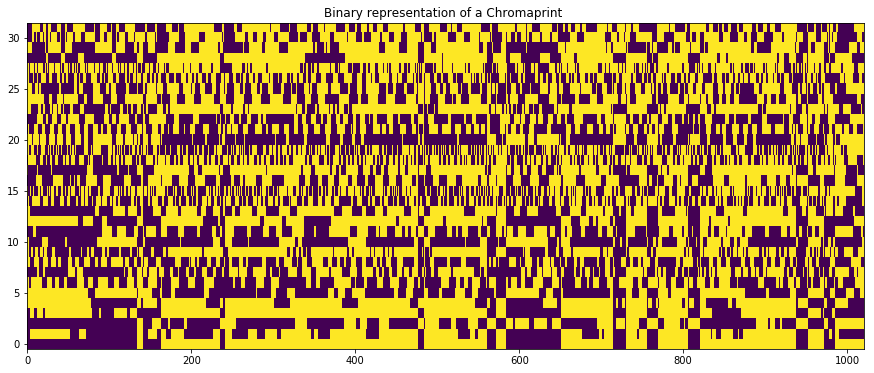

In [71]:
import acoustid as ai

fp_int = ai.chromaprint.decode_fingerprint(fp)[0]

fb_bin = [list('{:032b}'.format(abs(x))) for x  in fp_int] # Int to unsigned 32-bit array

arr = np.zeros([len(fb_bin), len(fb_bin[0])])

for i in range(arr.shape[0]):
    arr[i,0] = int(fp_int[i] > 0) # The sign is added to the first bit
    for j in range(1, arr.shape[1]):
        arr[i,j] = float(fb_bin[i][j])
        
plt.imshow(arr.T, aspect='auto', origin='lower')
plt.title('Binary representation of a Chromaprint ')

### Using chromaprints to identify segments in an audio track
In this example, chromaprints are used to locate a segment of a larger piece after some modifications. This is an adaptation of [this gist](https://gist.github.com/lalinsky/1099996) by Lukáš Lalinský. In a real world application this technique could be used, for instance, to identify songs in a DJ set stream. In this example, we will work on a short fragment of Mozart and we will try to identify the phrase among bars from the next plot.

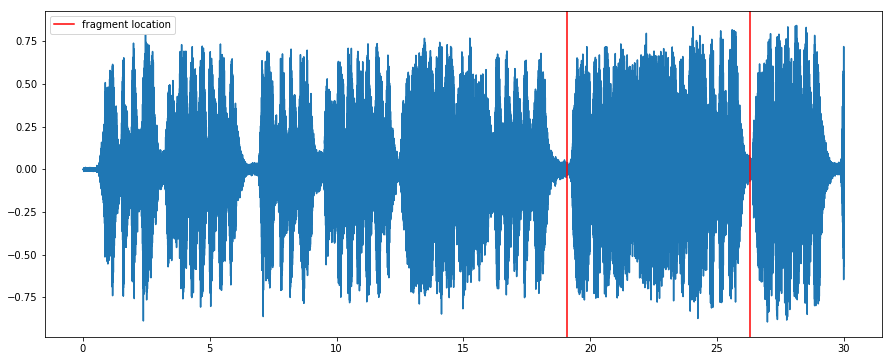

In [177]:
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

fs=44100
audio = es.MonoLoader(filename='../../../test/audio/recorded/mozart_c_major_30sec.wav', sampleRate=fs)() # this song is not available
time = np.linspace(0, len(audio)/float(fs), len(audio))

plot(time, audio)

# Segment limits
start = 19.1
end = 26.3

plt.axvline(x=start, color='red', label='fragment location')
plt.axvline(x=end, color='red')
plt.legend()

This is how the track sounds like:

In [105]:
IPython.display.Audio(audio, rate=44100)

In order to show the robustness of the fingerprinting algorithm, we will apply a 1st order lowpass filter tuned to 16kHz. This kind of filtering is one of the differences observed between low bitrate MP3 files and their original WAV, so the fingerprinting algorithm should be robust to this sort of alterations.

In [176]:
fragment = audio[int(start*fs):int(end*fs)]
fragment = es.LowPass(cutoffFrequency=16000)(fragment)

IPython.display.Audio(fragment, rate=44100)

The first step is to compute and uncompress the chromaprints of the full track and the modified segment.

In [168]:
import acoustid as ai
fp_full_char = es.Chromaprinter()(audio)
fp_frag_char = es.Chromaprinter()(fragment)

fp_full = ai.chromaprint.decode_fingerprint(fp_full_char)[0]
fp_frag = ai.chromaprint.decode_fingerprint(fp_frag_char)[0]

The identification proccess starts by finding the common items (or frames) of the chromaprints. At this stage, only the 20 most significative bits are used.

In [169]:
full_20bit = [x & (1<<20 - 1) for x in fp_full]
short_20bit = [x & (1<<20 - 1) for x in fp_frag]

common = set(full_20bit) & set(short_20bit)

For convenience, a reversed dictionary is created to access the timestamps given the 20-bit values.

In [171]:
def invert(arr):
    """
    Make a dictionary that with the array elements as keys and
    their positions positions as values.
    """
    map = {}
    for i, a in enumerate(arr):
        map.setdefault(a, []).append(i)
    return map

i_full_20bit = invert(full_20bit)
i_short_20bit = invert(short_20bit)

Now the offsets among the common items are stored:

In [172]:
offsets = {}
for a in common:
    for i in i_full_20bit[a]:
        for j in i_short_20bit[a]:
            o = i - j
            offsets[o] = offsets.get(o, 0) + 1

All the detected offsets are filtered and scored. The criterium for filtering is the greatest number of common events. In this example, only the 20 top offsets are considered. The final score is computed by measuring the bit-wise distance of the 32-bit vectors given the proposed offsets.

In [173]:
popcnt_table_8bit = [
    0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4,1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,4,5,5,6,5,6,6,7,5,6,6,7,6,7,7,8,
]

def popcnt(x):
    """
    Count the number of set bits in the given 32-bit integer.
    """
    return (popcnt_table_8bit[(x >>  0) & 0xFF] +
            popcnt_table_8bit[(x >>  8) & 0xFF] +
            popcnt_table_8bit[(x >> 16) & 0xFF] +
            popcnt_table_8bit[(x >> 24) & 0xFF])


def ber(offset):
    """
    Compare the short snippet against the full track at given offset.
    """
    errors = 0
    count = 0
    for a, b in zip(fp_full[offset:], fp_frag):
        errors += popcnt(a ^ b)
        count += 1
    return max(0.0, 1.0 - 2.0 * errors / (32.0 * count))

matches = []
for count, offset in sorted([(v, k) for k, v in offsets.items()], reverse=True)[:20]:
    matches.append((ber(offset), offset))
matches.sort(reverse=True)

The offset with the best score is considered the optimal location of the segment.

position 0:19 with score 0.937500


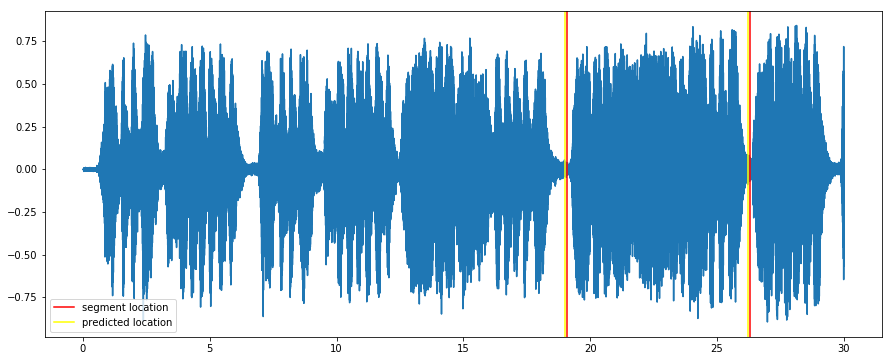

In [178]:
score, offset = matches[0]

offset_secs =int(offset * 0.1238) # each fingerprint item represents 0.1238 seconds

fp_duration = len(fp_frag) * 0.1238 + 2.6476 # there is also a duration offset found empirically

print "position %d:%02d with score %f" % (offset_secs / 60, offset_secs % 60, score)

plot(time, audio)

plt.axvline(x=start, color='red', label= 'segment location')
plt.axvline(x=end, color='red')

plt.axvline(x=offset_secs, color='yellow', label='predicted location')
plt.axvline(x=offset_secs + fp_duration, color='yellow')
plt.legend()